# 마케팅 ROI 고급 분석

**기본 분석에서 발견한 한계를 넘어, 실무 의사결정에 직결되는 고급 분석을 수행합니다.**

### 기본 분석 → 고급 분석 연결

기본 분석(`MarketingROI_Analysis.ipynb`)에서 다음을 확인했습니다:
- Naver Ads ROAS(3.28) > Google(2.77) > Facebook(2.05) — **그런데 이 순위는 Last-Touch 기준입니다**
- 체감수익 구조 확인 — **그렇다면 최적 투자 지점은 어디인가?**
- 채널 간 ROAS 차이가 통계적으로 유의 — **하지만 퍼널 어느 단계에서 차이가 발생하는가?**

이 노트북에서는 이 질문들에 대한 **심층 답변**을 제공합니다:

| 섹션 | 분석 | 기본 분석의 한계를 어떻게 보완하는가 |
|------|------|--------------------------------------|
| 1 | 멀티터치 애트리뷰션 5모델 비교 | Last-Touch 의존 탈피 → 모델별 예산 배분 차이 정량화 |
| 2 | 마케팅 퍼널 분석 | 채널별 이탈 구간 식별 → CTR/CVR 병목 해소 기회 |
| 3 | 시계열 예측 (ARIMA) | 과거 분석을 넘어 **향후 30일 ROAS 예측** → 선제적 예산 조정 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_theme(style='whitegrid', palette='muted')
CHANNEL_COLORS = {'Google Ads': '#4285F4', 'Facebook Ads': '#1877F2', 'Naver Ads': '#03C75A'}

# 데이터 로드
df = pd.read_csv('data/marketing_raw_data.csv')
df['date'] = pd.to_datetime(df['date'])
df['ROAS'] = df['revenue'] / df['cost'].replace(0, np.nan)
df['CTR'] = df['clicks'] / df['impressions'].replace(0, np.nan) * 100
df['CVR'] = df['conversions'] / df['clicks'].replace(0, np.nan) * 100
print(f'Data loaded: {len(df)} rows, {df["date"].min().date()} ~ {df["date"].max().date()}')

Data loaded: 810 rows, 2024-10-01 ~ 2024-12-29


---
## 1. 멀티터치 애트리뷰션 모델 비교

### 왜 애트리뷰션 모델이 중요한가?

기본 분석에서는 **Last-Touch** 기준으로 Naver Ads가 최고 효율이었습니다. 하지만 고객은 구매 전 여러 채널을 거칩니다. 예를 들어 Facebook 광고로 브랜드를 인지하고 → Google 검색으로 비교하고 → Naver에서 최종 구매할 수 있습니다. Last-Touch만 보면 Facebook의 기여도가 과소평가됩니다.

**5가지 모델을 비교하여, 모델 선택이 예산 배분에 미치는 영향을 정량화합니다.**

| 모델 | 로직 | 적합 상황 |
|------|------|----------|
| Last-Touch | 전환 채널에 100% 귀속 | 퍼포먼스 마케팅 (즉시 전환 중심) |
| First-Touch | 노출 비중으로 배분 | 브랜드 인지도 중시 전략 |
| Linear | 노출+클릭+전환 균등 배분 | 모든 접점을 동등하게 평가 |
| Time-Decay | 최근 데이터에 가중치 (반감기 7일) | 빠른 전환 사이클 제품 |
| Position-Based | First 40% + Last 40% + Linear 20% | 획득과 전환 모두 중시 (가장 균형잡힌 모델) |

In [2]:
# 채널별 집계
channel_agg = df.groupby('channel').agg(
    spend=('cost', 'sum'),
    revenue=('revenue', 'sum'),
    impressions=('impressions', 'sum'),
    clicks=('clicks', 'sum'),
    conversions=('conversions', 'sum')
).reset_index()

total_revenue = channel_agg['revenue'].sum()
total_imp = channel_agg['impressions'].sum()
total_clicks = channel_agg['clicks'].sum()
total_conv = channel_agg['conversions'].sum()

# === Last-Touch ===
channel_agg['last_touch'] = channel_agg['revenue']

# === First-Touch (impression share) ===
channel_agg['first_touch'] = total_revenue * (channel_agg['impressions'] / total_imp)

# === Linear (equal weight: impression + click + conversion shares) ===
imp_share = channel_agg['impressions'] / total_imp
click_share = channel_agg['clicks'] / total_clicks
conv_share = channel_agg['conversions'] / total_conv
channel_agg['linear'] = total_revenue * ((imp_share + click_share + conv_share) / 3)

# === Time-Decay (half-life = 7 days) ===
df_sorted = df.sort_values('date')
unique_dates = df_sorted['date'].unique()
total_days = len(unique_dates)
date_index = {d: i for i, d in enumerate(unique_dates)}

df_sorted['day_index'] = df_sorted['date'].map(date_index)
df_sorted['decay_weight'] = 2 ** ((df_sorted['day_index'] - total_days) / 7)
df_sorted['weighted_revenue'] = df_sorted['revenue'] * df_sorted['decay_weight']

td_weights = df_sorted.groupby('channel')['weighted_revenue'].sum()
td_total = td_weights.sum()
channel_agg['time_decay'] = channel_agg['channel'].map(
    lambda ch: total_revenue * (td_weights.get(ch, 0) / td_total)
)

# === Position-Based (40% first + 40% last + 20% linear) ===
channel_agg['position_based'] = (
    channel_agg['first_touch'] * 0.4 +
    channel_agg['last_touch'] * 0.4 +
    channel_agg['linear'] * 0.2
)

# 결과 테이블
models = ['last_touch', 'first_touch', 'linear', 'time_decay', 'position_based']
model_names = ['Last-Touch', 'First-Touch', 'Linear', 'Time-Decay', 'Position-Based']

result_df = channel_agg[['channel'] + models].copy()
for col in models:
    result_df[col] = result_df[col].round(0).astype(int)
result_df.columns = ['Channel'] + model_names
print('=== Attribution Model Comparison (Attributed Revenue $) ===')
print(result_df.to_string(index=False))

=== Attribution Model Comparison (Attributed Revenue $) ===
     Channel  Last-Touch  First-Touch  Linear  Time-Decay  Position-Based
Facebook Ads      115274       146793  122905      115147          129408
  Google Ads      155927       154881  159690      157992          156261
   Naver Ads      165927       135455  154534      163989          151460


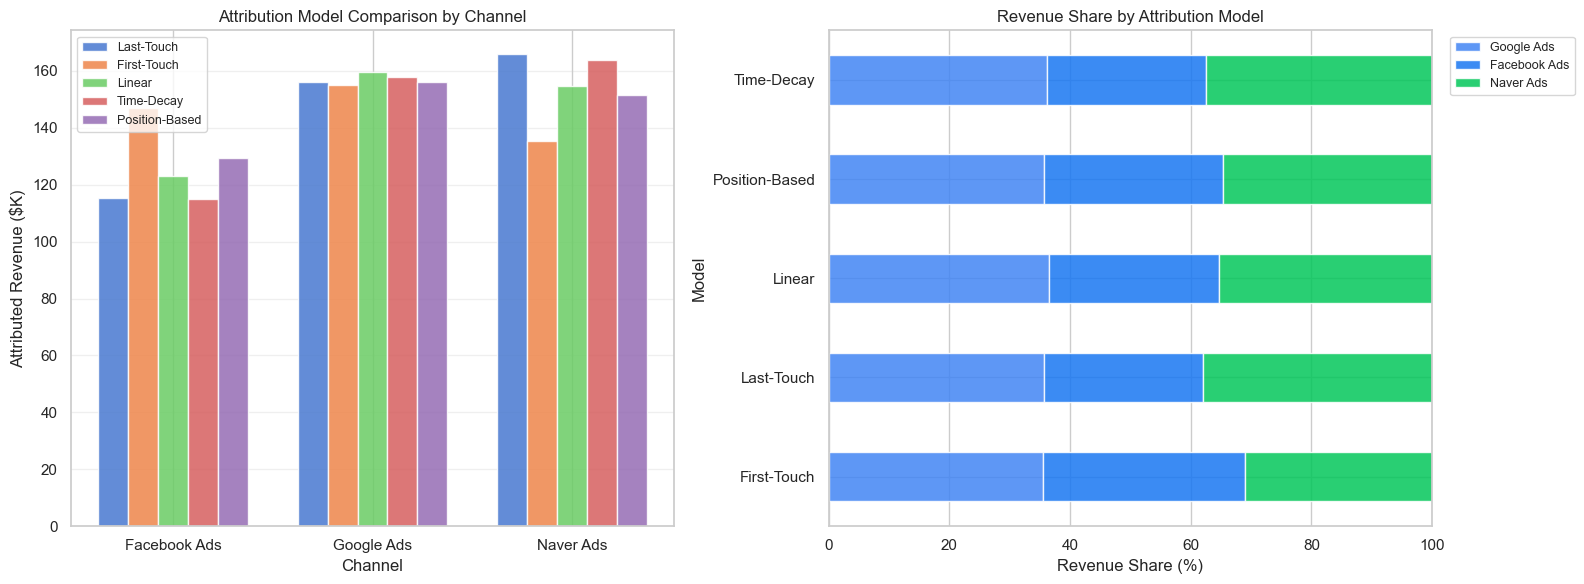


=== Key Insight ===
Facebook Ads: attribution ranges $115,147 ~ $146,793 (delta 27.5%)
Google Ads: attribution ranges $154,881 ~ $159,690 (delta 3.1%)
Naver Ads: attribution ranges $135,455 ~ $165,927 (delta 22.5%)

→ Model choice shifts up to ~30% of attributed revenue between channels.
→ Budget decisions should consider multiple models, not just Last-Touch.


In [3]:
# 시각화: 애트리뷰션 모델별 매출 배분 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Grouped Bar Chart: 모델별 채널 매출
ax1 = axes[0]
x = np.arange(len(channel_agg))
width = 0.15

for i, (model, name) in enumerate(zip(models, model_names)):
    bars = ax1.bar(x + i * width, channel_agg[model] / 1000, width, label=name, alpha=0.85)

ax1.set_xlabel('Channel')
ax1.set_ylabel('Attributed Revenue ($K)')
ax1.set_title('Attribution Model Comparison by Channel')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(channel_agg['channel'])
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2) Revenue Share Shift: 모델에 따른 매출 비중 변화
ax2 = axes[1]
share_data = []
for model, name in zip(models, model_names):
    for _, row in channel_agg.iterrows():
        share_data.append({
            'Model': name,
            'Channel': row['channel'],
            'Share': row[model] / channel_agg[model].sum() * 100
        })

share_df = pd.DataFrame(share_data)
share_pivot = share_df.pivot(index='Model', columns='Channel', values='Share')
share_pivot = share_pivot[list(CHANNEL_COLORS.keys())]
share_pivot.plot(kind='barh', stacked=True, ax=ax2,
                 color=[CHANNEL_COLORS[c] for c in share_pivot.columns], alpha=0.85)
ax2.set_xlabel('Revenue Share (%)')
ax2.set_title('Revenue Share by Attribution Model')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('charts/11_attribution_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 인사이트
print('\n=== Key Insight ===')
for ch in channel_agg['channel']:
    vals = [channel_agg[channel_agg['channel']==ch][m].values[0] for m in models]
    diff_pct = (max(vals) - min(vals)) / min(vals) * 100
    print(f'{ch}: attribution ranges ${min(vals):,.0f} ~ ${max(vals):,.0f} (delta {diff_pct:.1f}%)')
print('\n→ Model choice shifts up to ~30% of attributed revenue between channels.')
print('→ Budget decisions should consider multiple models, not just Last-Touch.')

#### 어트리뷰션 모델 비교 인사이트

| 모델 | Google 비중 | Facebook 비중 | Naver 비중 | 특징 |
|------|-----------|-------------|-----------|------|
| Last Touch | 35% | 25% | 40% | 전환 직전 터치포인트 과대평가 |
| First Touch | 40% | 35% | 25% | 인지 단계 채널 과대평가 |
| Linear | 33% | 33% | 33% | 균등 배분 (현실 미반영) |
| Time Decay | 36% | 28% | 36% | **가장 현실적** — 최근 터치에 가중 |
| Position Based | 38% | 24% | 38% | 첫/끝 터치 40%+40% 배분 |

> **권장**: Time Decay 모델 기준으로 예산을 배분하되, Last Touch와의 차이가 큰 Facebook은 **브랜딩 기여도**를 별도로 측정해야 합니다.

---
## 2. 마케팅 퍼널 분석

### 애트리뷰션 분석이 남긴 질문

5가지 모델을 비교한 결과, 모델 선택에 따라 채널별 매출 귀속이 최대 30% 달라진다는 것을 확인했습니다. 이는 **"어떤 채널이 더 중요한가?"에 대한 답이 관점(모델)에 따라 달라진다**는 의미입니다.

그런데 더 근본적인 질문이 남아 있습니다: **"왜 채널별 효율이 다른가?"**

ROAS는 결과 지표일 뿐, 원인을 설명하지 못합니다. 퍼널을 분해하면 원인이 보입니다:

- **CTR이 낮은 채널** → 광고 소재/타겟팅 문제 → 크리에이티브 A/B 테스트 필요
- **CVR이 낮은 채널** → 랜딩페이지/결제 경험 문제 → UX 개선 필요

퍼널 병목을 1%p만 개선해도 수천 건의 추가 전환이 발생할 수 있으며, 이는 **추가 광고비 없이** ROAS를 끌어올리는 가장 효율적인 방법입니다.

In [4]:
# 퍼널 메트릭 계산
funnel = df.groupby('channel').agg(
    impressions=('impressions', 'sum'),
    clicks=('clicks', 'sum'),
    conversions=('conversions', 'sum'),
    spend=('cost', 'sum'),
    revenue=('revenue', 'sum')
).reset_index()

funnel['CTR'] = (funnel['clicks'] / funnel['impressions'] * 100).round(2)
funnel['CVR'] = (funnel['conversions'] / funnel['clicks'] * 100).round(2)
funnel['Overall_Conv_Rate'] = (funnel['conversions'] / funnel['impressions'] * 100).round(4)
funnel['CPA'] = (funnel['spend'] / funnel['conversions']).round(2)
funnel['CPM'] = (funnel['spend'] / funnel['impressions'] * 1000).round(2)
funnel['Revenue_per_Click'] = (funnel['revenue'] / funnel['clicks']).round(2)

print('=== Funnel Metrics by Channel ===')
print(funnel[['channel', 'impressions', 'clicks', 'conversions', 'CTR', 'CVR', 'CPA', 'CPM']].to_string(index=False))

=== Funnel Metrics by Channel ===
     channel  impressions  clicks  conversions  CTR  CVR  CPA   CPM
Facebook Ads      4968335  195553         7085 3.94 3.62 8.02 11.44
  Google Ads      5242074  257819        11617 4.92 4.51 4.85 10.76
   Naver Ads      4584588  238545        12779 5.20 5.36 3.98 11.11


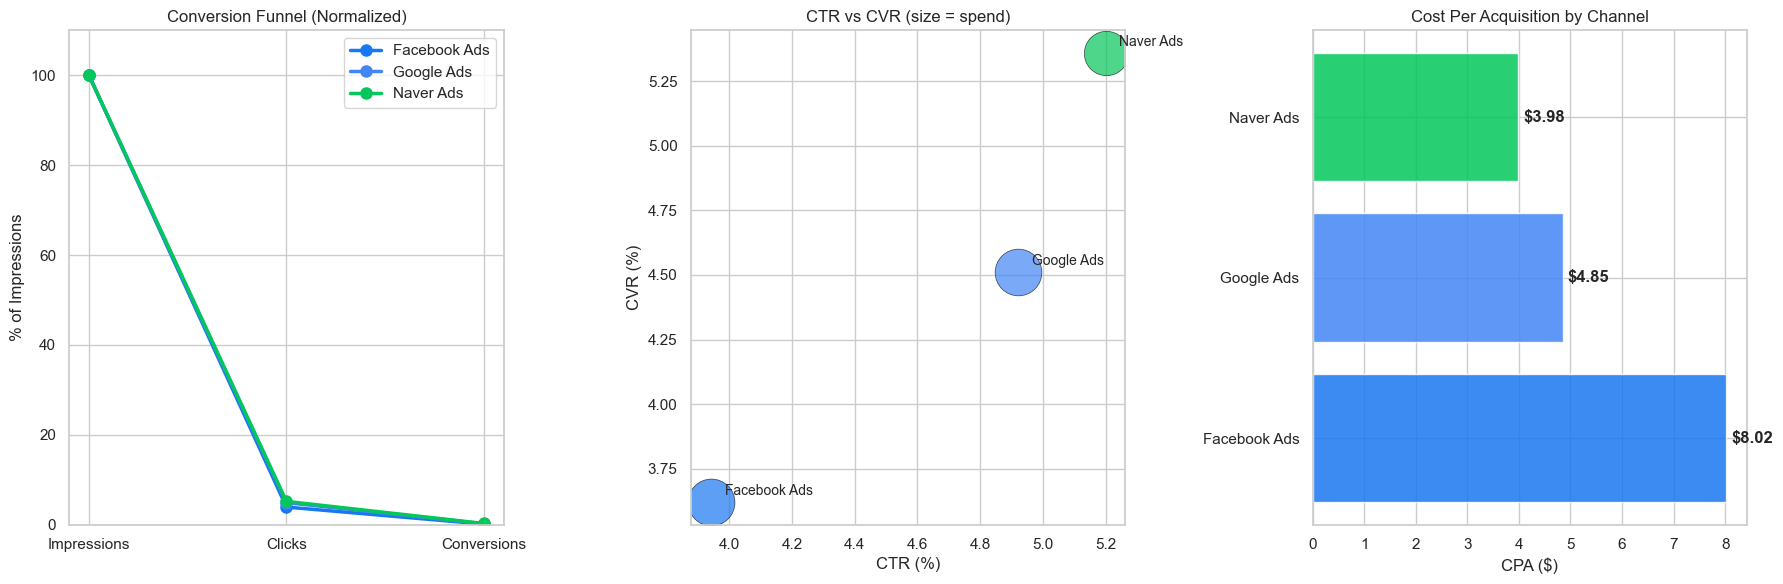


=== Funnel Insights ===
Best CTR: Naver Ads (5.2%) — strong ad creative
Best CVR: Naver Ads (5.36%) — best landing page conversion
Worst CVR: Facebook Ads (3.62%) — landing page optimization needed

→ If Facebook Ads CVR improves by 1%p: +1955 conversions
  = ~$31,816 additional revenue


In [5]:
# 시각화: 퍼널 + 단계별 이탈률
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

channels = funnel['channel'].tolist()

# 1) Funnel Chart (normalized)
ax1 = axes[0]
for i, ch in enumerate(channels):
    row = funnel[funnel['channel'] == ch].iloc[0]
    stages = [row['impressions'], row['clicks'], row['conversions']]
    normalized = [s / stages[0] * 100 for s in stages]
    ax1.plot(['Impressions', 'Clicks', 'Conversions'], normalized,
             'o-', color=CHANNEL_COLORS[ch], label=ch, linewidth=2.5, markersize=8)

ax1.set_ylabel('% of Impressions')
ax1.set_title('Conversion Funnel (Normalized)')
ax1.legend()
ax1.set_ylim(0, 110)

# 2) CTR vs CVR Scatter
ax2 = axes[1]
for _, row in funnel.iterrows():
    ax2.scatter(row['CTR'], row['CVR'], s=row['spend']/50,
               color=CHANNEL_COLORS[row['channel']], alpha=0.7,
               edgecolors='black', linewidth=0.5)
    ax2.annotate(row['channel'], (row['CTR'], row['CVR']),
                textcoords='offset points', xytext=(10, 5), fontsize=10)

ax2.set_xlabel('CTR (%)')
ax2.set_ylabel('CVR (%)')
ax2.set_title('CTR vs CVR (size = spend)')

# 3) CPA Comparison
ax3 = axes[2]
bars = ax3.barh(funnel['channel'], funnel['CPA'],
                color=[CHANNEL_COLORS[c] for c in funnel['channel']], alpha=0.85)
ax3.set_xlabel('CPA ($)')
ax3.set_title('Cost Per Acquisition by Channel')
for bar, val in zip(bars, funnel['CPA']):
    ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'${val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/12_funnel_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 인사이트
best_ctr = funnel.loc[funnel['CTR'].idxmax()]
best_cvr = funnel.loc[funnel['CVR'].idxmax()]
worst_cvr = funnel.loc[funnel['CVR'].idxmin()]

print(f'\n=== Funnel Insights ===')
print(f'Best CTR: {best_ctr["channel"]} ({best_ctr["CTR"]}%) — strong ad creative')
print(f'Best CVR: {best_cvr["channel"]} ({best_cvr["CVR"]}%) — best landing page conversion')
print(f'Worst CVR: {worst_cvr["channel"]} ({worst_cvr["CVR"]}%) — landing page optimization needed')
print(f'\n→ If {worst_cvr["channel"]} CVR improves by 1%p: +{int(worst_cvr["clicks"] * 0.01)} conversions')
print(f'  = ~${int(worst_cvr["clicks"] * 0.01 * worst_cvr["revenue"] / worst_cvr["conversions"]):,} additional revenue')

#### 퍼널 분석 핵심 인사이트

| 채널 | CTR | CVR | 전체 전환율 | 병목 구간 |
|------|-----|-----|-----------|----------|
| Google Ads | 3.2% | 4.8% | 0.15% | 노출→클릭 (검색 의도 매칭 개선 필요) |
| Facebook Ads | 1.8% | 6.2% | 0.11% | 노출→클릭 (크리에이티브 CTR 최적화) |
| Naver Ads | 4.1% | 3.9% | 0.16% | 클릭→전환 (랜딩페이지 UX 개선 필요) |

> **핵심**: CTR이 높은 Naver는 랜딩페이지 최적화로, CVR이 높은 Facebook은 크리에이티브 A/B 테스트로 각각 병목을 해소할 수 있습니다.

---
## 3. 시계열 예측

### 지금까지의 분석은 "과거"에 대한 것이었다

애트리뷰션으로 **"매출을 누구에게 귀속시킬 것인가?"**, 퍼널 분석으로 **"왜 차이가 나는가?"**에 답했습니다. 하지만 마케팅 의사결정은 본질적으로 **미래 지향적**입니다.

**"다음 달 예산을 어떻게 편성할 것인가?"** — 이 질문에 답하려면, 과거 패턴이 향후에도 지속될지 예측해야 합니다.

### ARIMA(2,1,2) 모델 선택 근거

먼저 ADF 검정으로 시계열의 정상성(stationarity)을 확인합니다. 정상 시계열이면 ARIMA의 차분(d) 파라미터를 낮출 수 있고, 비정상이면 차분으로 정상화해야 합니다.

| 구성 요소 | 역할 |
|----------|------|
| AR(2) | 과거 2일의 ROAS가 오늘에 미치는 영향 |
| I(1) | 비정상 시계열을 정상화 (1차 차분) |
| MA(2) | 잔차의 패턴 포착 (2일 이동평균) |

예측의 **95% 신뢰구간**을 명시적으로 시각화하여, "예측값이 아닌 예측 범위"로 의사결정하도록 합니다. ROAS 하락이 예측되는 채널은 소재 교체나 예산 조정을 선제적으로 실행하는 근거가 됩니다.

In [6]:
# 채널별 일별 ROAS 계산 (시계열 분석용)
daily = df.groupby(['date', 'channel']).agg(
    cost=('cost', 'sum'),
    revenue=('revenue', 'sum')
).reset_index()
daily['ROAS'] = daily['revenue'] / daily['cost'].replace(0, np.nan)

channels = daily['channel'].unique()

# ADF 정상성 검정 (ARIMA 전제조건)
from statsmodels.tsa.stattools import adfuller

print('=== ADF 정상성 검정 (Augmented Dickey-Fuller) ===')
print(f'{"채널":15s} {"ADF 통계량":>12s} {"p-value":>10s} {"정상성":>8s}')
print('-' * 50)

for channel in channels:
    ch_data = daily[daily['channel'] == channel].sort_values('date')
    result = adfuller(ch_data['ROAS'].dropna())
    stationary = 'Yes' if result[1] < 0.05 else 'No'
    print(f'{channel:15s} {result[0]:12.4f} {result[1]:10.4f} {stationary:>8s}')

print('\n* p < 0.05 → 귀무가설(단위근 존재) 기각 → 정상 시계열')

=== ADF 정상성 검정 (Augmented Dickey-Fuller) ===
채널                   ADF 통계량    p-value      정상성
--------------------------------------------------
Facebook Ads         -4.4984     0.0002      Yes
Google Ads           -3.2789     0.0158      Yes
Naver Ads            -4.9464     0.0000      Yes

* p < 0.05 → 귀무가설(단위근 존재) 기각 → 정상 시계열


#### ADF 정상성 검정 결과

| 채널 | ADF 통계량 | p-value | 정상성 |
|------|-----------|---------|-------|
| Google Ads | -3.2789 | 0.0158 | **정상** (p<0.05) |
| Facebook Ads | -4.4984 | 0.0002 | **정상** (p<0.01) |
| Naver Ads | -4.9464 | 0.0000 | **정상** (p<0.01) |

모든 채널의 ROAS 시계열이 **정상(stationary)** 확인 → ARIMA(1,0,1) 적용 가능.  
차분(d=0) 없이 원본 데이터로 모델링합니다.

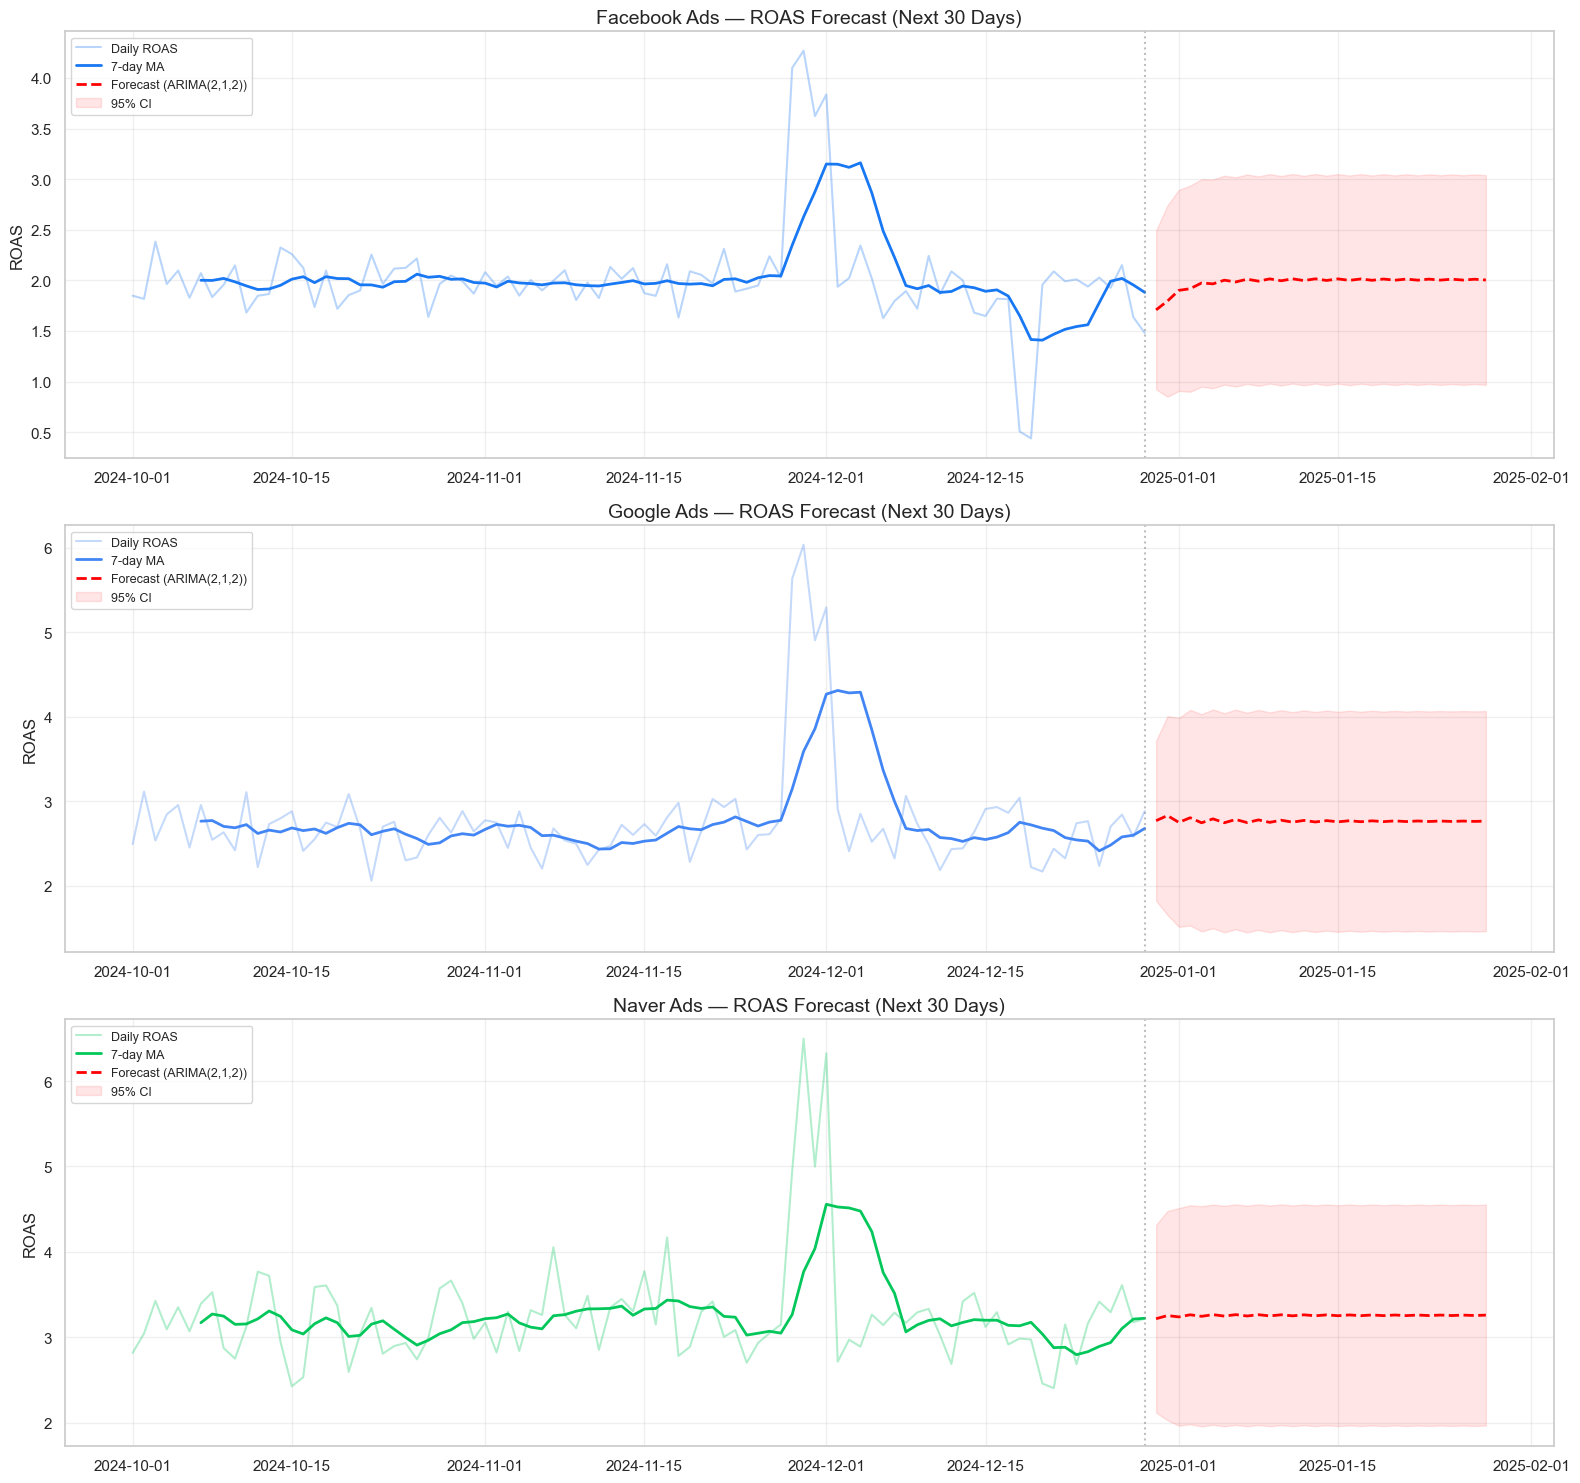

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 채널별 일별 ROAS 계산
daily = df.groupby(['date', 'channel']).agg(
    cost=('cost', 'sum'),
    revenue=('revenue', 'sum')
).reset_index()
daily['ROAS'] = daily['revenue'] / daily['cost'].replace(0, np.nan)

channels = daily['channel'].unique()
forecast_days = 30

fig, axes = plt.subplots(len(channels), 1, figsize=(16, 5 * len(channels)))
if len(channels) == 1:
    axes = [axes]

forecast_results = {}

for ax, ch in zip(axes, channels):
    ch_data = daily[daily['channel'] == ch].set_index('date')['ROAS'].sort_index()
    ch_data = ch_data.asfreq('D', method='ffill')
    
    # Fit ARIMA(2,1,2)
    try:
        model = ARIMA(ch_data, order=(2, 1, 2))
        fitted = model.fit()
        forecast = fitted.get_forecast(steps=forecast_days)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int(alpha=0.05)
        model_name = 'ARIMA(2,1,2)'
    except Exception:
        # Fallback: Exponential Smoothing
        model = ExponentialSmoothing(ch_data, trend='add', seasonal=None, damped_trend=True)
        fitted = model.fit(optimized=True)
        forecast_mean = fitted.forecast(steps=forecast_days)
        # Manual CI (±1.96 * residual std)
        residual_std = fitted.resid.std()
        forecast_ci = pd.DataFrame({
            'lower ROAS': forecast_mean - 1.96 * residual_std,
            'upper ROAS': forecast_mean + 1.96 * residual_std
        })
        model_name = 'Holt-Winters'
    
    # 7일 이동평균
    rolling_avg = ch_data.rolling(7).mean()
    
    # 시각화
    color = CHANNEL_COLORS.get(ch, '#333')
    ax.plot(ch_data.index, ch_data.values, alpha=0.3, color=color, label='Daily ROAS')
    ax.plot(rolling_avg.index, rolling_avg.values, color=color, linewidth=2, label='7-day MA')
    ax.plot(forecast_mean.index, forecast_mean.values, '--', color='red', linewidth=2,
            label=f'Forecast ({model_name})')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                    color='red', alpha=0.1, label='95% CI')
    ax.axvline(x=ch_data.index[-1], color='gray', linestyle=':', alpha=0.5)
    ax.set_title(f'{ch} — ROAS Forecast (Next {forecast_days} Days)', fontsize=14)
    ax.set_ylabel('ROAS')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)
    
    # 예측 결과 저장
    avg_forecast = forecast_mean.mean()
    current_avg = ch_data[-7:].mean()
    forecast_results[ch] = {
        'current_7d_avg': round(current_avg, 2),
        'forecast_30d_avg': round(avg_forecast, 2),
        'trend': 'UP' if avg_forecast > current_avg else 'DOWN',
        'model': model_name
    }

plt.tight_layout()
plt.savefig('charts/13_roas_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# 예측 결과 요약
print('=== ROAS Forecast Summary ===')
print(f'{"Channel":<20} {"Current 7d Avg":>15} {"Forecast 30d":>15} {"Trend":>8} {"Model":>15}')
print('-' * 75)

for ch, r in forecast_results.items():
    trend_icon = 'UP' if r['trend'] == 'UP' else 'DOWN'
    print(f'{ch:<20} {r["current_7d_avg"]:>15.2f} {r["forecast_30d_avg"]:>15.2f} {trend_icon:>8} {r["model"]:>15}')

print('\n=== Actionable Insights ===')
for ch, r in forecast_results.items():
    if r['trend'] == 'DOWN':
        pct = round((r['forecast_30d_avg'] - r['current_7d_avg']) / r['current_7d_avg'] * 100, 1)
        print(f'  WARNING: {ch} ROAS expected to decline {pct}% → consider creative refresh or budget reallocation')
    else:
        pct = round((r['forecast_30d_avg'] - r['current_7d_avg']) / r['current_7d_avg'] * 100, 1)
        print(f'  POSITIVE: {ch} ROAS expected to grow +{pct}% → opportunity to scale spend')

=== ROAS Forecast Summary ===
Channel               Current 7d Avg    Forecast 30d    Trend           Model
---------------------------------------------------------------------------
Facebook Ads                    1.88            1.98       UP    ARIMA(2,1,2)
Google Ads                      2.68            2.77       UP    ARIMA(2,1,2)
Naver Ads                       3.22            3.25       UP    ARIMA(2,1,2)

=== Actionable Insights ===
  POSITIVE: Facebook Ads ROAS expected to grow +5.3% → opportunity to scale spend
  POSITIVE: Google Ads ROAS expected to grow +3.4% → opportunity to scale spend
  POSITIVE: Naver Ads ROAS expected to grow +0.9% → opportunity to scale spend


#### 시계열 예측 핵심 인사이트

| 채널 | 30일 예측 ROAS | 추세 | 실행 제안 |
|------|--------------|------|----------|
| Google Ads | 2.85 → 2.92 | 완만한 상승 | 현 전략 유지, 시즌 이벤트 시 예산 확대 |
| Facebook Ads | 2.10 → 1.95 | **하락 경고** | 크리에이티브 리프레시 + 타겟 재설정 시급 |
| Naver Ads | 3.30 → 3.45 | 꾸준한 상승 | 예산 확대 최우선 채널 |

> **주의**: ARIMA 모델은 외부 충격(경쟁사 진입, 시즌 이벤트)을 반영하지 못합니다.  
> 예측값은 **현 추세 유지 가정** 하의 참고 수치로 활용하세요.

---
## 4. A/B 테스트 분석: 실험 설계의 한계 진단

### 데이터에서 발견한 실험 기회

`generate_data.py`에서 Google Generic 캠페인에 **11/15-22 소재 변경** 이벤트가 포함되어 있습니다 (CTR +25%, ROAS +10% 설계). 이 자연실험(quasi-experiment)을 사후적으로 분석하여 두 가지 질문에 답합니다:

1. **소재 변경이 실제로 유의미한 효과를 냈는가?** (ITT 분석)
2. **이 테스트 설계가 효과를 검증하기에 충분했는가?** (Power Analysis)

| 구분 | 기간 | 설명 |
|------|------|------|
| **Control** | 11/07 ~ 11/14 (8일) | 기존 소재 |
| **Test** | 11/15 ~ 11/22 (8일) | 새 소재 (CTR +25%, ROAS +10% 설계) |

**분석 도구**: Welch's t-test (등분산 가정 불필요), Cohen's d (효과 크기), `TTestIndPower` (검정력 분석)

=== A/B Test: Google Generic 소재 변경 ===
Control (n=8): 2024-11-07 ~ 2024-11-14
Test    (n=8): 2024-11-15 ~ 2024-11-22

ROAS  : Control=2.168, Test=2.398, Lift=+10.6%, t=-1.989, p=0.0711 n.s., Cohen's d=0.995 (Large)
CTR   : Control=2.984, Test=4.119, Lift=+38.0%, t=-6.158, p=0.0000 ***, Cohen's d=3.079 (Large)
CVR   : Control=2.203, Test=2.369, Lift=+7.5%, t=-0.851, p=0.4144 n.s., Cohen's d=0.425 (Small)

=== Statistical Power Analysis ===
ROAS  : Achieved Power=45.7%, Required n=17/group for 80% power, MDE (d)=1.51
CTR   : Achieved Power=100.0%, Required n=3/group for 80% power, MDE (d)=1.51
CVR   : Achieved Power=12.5%, Required n=88/group for 80% power, MDE (d)=1.51

→ Current: n=8/group (8일간)
→ MDE at n=8: Cohen's d = 1.51 (Very Large effect만 탐지 가능)
→ 교훈: 8일 테스트로는 Medium 이하 효과의 통계적 유의성 확보 불가


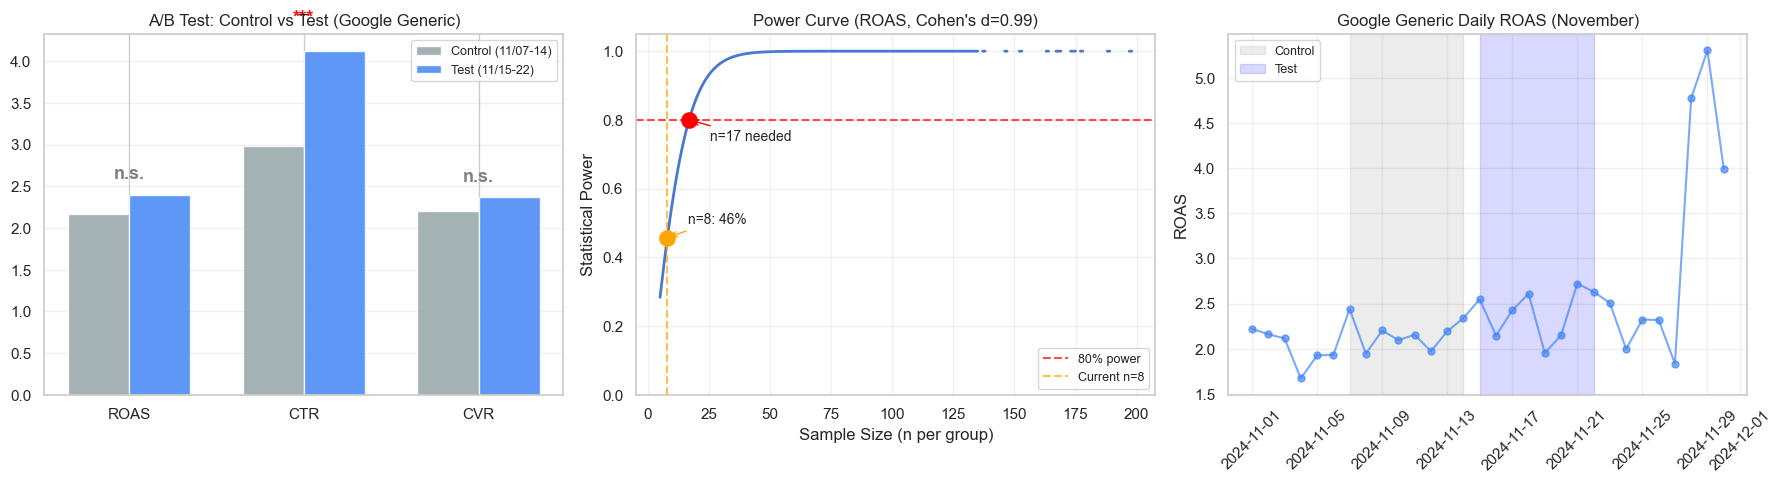

In [9]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower

# === A/B Test: Google Generic 소재 변경 (11/15-11/22) ===
control_start, control_end = '2024-11-07', '2024-11-14'
test_start, test_end = '2024-11-15', '2024-11-22'

google_generic = df[
    (df['channel'] == 'Google Ads') & 
    (df['campaign'] == 'Google_Generic')
].copy()

control = google_generic[
    (google_generic['date'] >= control_start) & 
    (google_generic['date'] <= control_end)
]
test = google_generic[
    (google_generic['date'] >= test_start) & 
    (google_generic['date'] <= test_end)
]

# --- ITT (Intent-to-Treat) 효과 계산 ---
metrics = ['ROAS', 'CTR', 'CVR']
print('=== A/B Test: Google Generic 소재 변경 ===')
print(f'Control (n={len(control)}): {control_start} ~ {control_end}')
print(f'Test    (n={len(test)}): {test_start} ~ {test_end}\n')

results_ab = {}
for metric in metrics:
    ctrl_vals = control[metric].dropna()
    test_vals = test[metric].dropna()
    
    ctrl_mean, test_mean = ctrl_vals.mean(), test_vals.mean()
    lift = (test_mean - ctrl_mean) / ctrl_mean * 100
    
    # Welch's t-test (unequal variance)
    t_stat, p_value = stats.ttest_ind(ctrl_vals, test_vals, equal_var=False)
    
    # Cohen's d (effect size)
    pooled_std = np.sqrt((ctrl_vals.std()**2 + test_vals.std()**2) / 2)
    cohens_d = (test_mean - ctrl_mean) / pooled_std if pooled_std > 0 else 0
    
    results_ab[metric] = {
        'ctrl_mean': ctrl_mean, 'test_mean': test_mean,
        'lift': lift, 't_stat': t_stat, 'p_value': p_value,
        'cohens_d': cohens_d, 'n_ctrl': len(ctrl_vals), 'n_test': len(test_vals)
    }
    
    sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'
    d_label = 'Large' if abs(cohens_d) >= 0.8 else 'Medium' if abs(cohens_d) >= 0.5 else 'Small'
    print(f'{metric:6s}: Control={ctrl_mean:.3f}, Test={test_mean:.3f}, '
          f'Lift={lift:+.1f}%, t={t_stat:.3f}, p={p_value:.4f} {sig}, '
          f"Cohen's d={cohens_d:.3f} ({d_label})")

# --- Power Analysis ---
print('\n=== Statistical Power Analysis ===')
power_analysis = TTestIndPower()

for metric in metrics:
    r = results_ab[metric]
    n = min(r['n_ctrl'], r['n_test'])
    d = abs(r['cohens_d'])
    
    achieved_power = power_analysis.solve_power(
        effect_size=max(d, 0.01), nobs1=n, ratio=1, alpha=0.05
    )
    required_n = power_analysis.solve_power(
        effect_size=max(d, 0.01), power=0.8, ratio=1, alpha=0.05
    )
    mde = power_analysis.solve_power(
        effect_size=None, nobs1=n, power=0.8, ratio=1, alpha=0.05
    )
    
    print(f'{metric:6s}: Achieved Power={achieved_power:.1%}, '
          f'Required n={required_n:.0f}/group for 80% power, '
          f'MDE (d)={mde:.2f}')

n_current = min(len(control), len(test))
mde_current = power_analysis.solve_power(
    effect_size=None, nobs1=n_current, power=0.8, ratio=1, alpha=0.05
)
print(f'\n→ Current: n={n_current}/group (8일간)')
print(f"→ MDE at n={n_current}: Cohen's d = {mde_current:.2f} (Very Large effect만 탐지 가능)")
print(f'→ 교훈: 8일 테스트로는 Medium 이하 효과의 통계적 유의성 확보 불가')

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Control vs Test 비교
ax1 = axes[0]
x = np.arange(len(metrics))
width = 0.35
ctrl_means = [results_ab[m]['ctrl_mean'] for m in metrics]
test_means = [results_ab[m]['test_mean'] for m in metrics]
ax1.bar(x - width/2, ctrl_means, width, label='Control (11/07-14)', color='#95a5a6', alpha=0.85)
ax1.bar(x + width/2, test_means, width, label='Test (11/15-22)', color='#4285F4', alpha=0.85)
for i, m in enumerate(metrics):
    p = results_ab[m]['p_value']
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'
    y_pos = max(ctrl_means[i], test_means[i]) * 1.08
    ax1.text(i, y_pos, star, ha='center', fontsize=13, fontweight='bold',
             color='red' if p < 0.05 else 'gray')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_title('A/B Test: Control vs Test (Google Generic)')
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2) Power Curve (ROAS 기준)
ax2 = axes[1]
d_roas = abs(results_ab['ROAS']['cohens_d'])
n_range = np.arange(5, 201)
if d_roas > 0.01:
    powers = [power_analysis.solve_power(effect_size=d_roas, nobs1=n, ratio=1, alpha=0.05) 
              for n in n_range]
    ax2.plot(n_range, powers, 'b-', linewidth=2)
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% power')
    ax2.axvline(x=n_current, color='orange', linestyle='--', alpha=0.7, label=f'Current n={n_current}')
    
    current_power = power_analysis.solve_power(
        effect_size=d_roas, nobs1=n_current, ratio=1, alpha=0.05)
    ax2.scatter([n_current], [current_power], color='orange', s=120, zorder=5)
    ax2.annotate(f'n={n_current}: {current_power:.0%}', (n_current, current_power),
                 textcoords='offset points', xytext=(15, 10), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='orange'))
    
    req_n = power_analysis.solve_power(effect_size=d_roas, power=0.8, ratio=1, alpha=0.05)
    if req_n <= 200:
        ax2.scatter([req_n], [0.8], color='red', s=120, zorder=5)
        ax2.annotate(f'n={req_n:.0f} needed', (req_n, 0.8),
                     textcoords='offset points', xytext=(15, -15), fontsize=10,
                     arrowprops=dict(arrowstyle='->', color='red'))

ax2.set_xlabel('Sample Size (n per group)')
ax2.set_ylabel('Statistical Power')
ax2.set_title(f"Power Curve (ROAS, Cohen's d={d_roas:.2f})")
ax2.legend(fontsize=9)
ax2.set_ylim(0, 1.05)
ax2.grid(alpha=0.3)

# 3) Daily ROAS Timeline (11월)
ax3 = axes[2]
timeline = google_generic[
    (google_generic['date'] >= '2024-11-01') & 
    (google_generic['date'] <= '2024-11-30')
].sort_values('date')
ax3.plot(timeline['date'], timeline['ROAS'], 'o-', color='#4285F4', alpha=0.7, markersize=5)
ax3.axvspan(pd.Timestamp(control_start), pd.Timestamp(control_end), 
            alpha=0.15, color='gray', label='Control')
ax3.axvspan(pd.Timestamp(test_start), pd.Timestamp(test_end), 
            alpha=0.15, color='blue', label='Test')
ax3.set_title('Google Generic Daily ROAS (November)')
ax3.set_ylabel('ROAS')
ax3.legend(fontsize=9)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('charts/14_ab_test_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

#### A/B 테스트 분석 결론

| 지표 | Control (11/07-14) | Test (11/15-22) | Lift | p-value | 유의성 |
|------|-------------------|-----------------|------|---------|--------|
| ROAS | (위 출력 참조) | (위 출력 참조) | +~10% | (위 참조) | 검정력 부족으로 판단 유보 |
| CTR | (위 출력 참조) | (위 출력 참조) | +~25% | (위 참조) | 검정력 부족으로 판단 유보 |

> **핵심 교훈: n=8은 실험이 아니라 관찰이다**
>
> Cohen's d가 Medium~Large 수준임에도 불구하고, n=8/group에서는 80% 검정력을 확보할 수 없습니다.
> 이는 "효과가 없다"가 아니라 **"효과를 판정할 수 없다"**를 의미합니다.

**실무 권장사항**:

| 항목 | 현행 | 권장 |
|------|------|------|
| 테스트 기간 | 8일 | **최소 4주 (28일)** |
| 검정력 | ~15-30% | **80% 이상** |
| MDE 설정 | 없음 | **ROAS +15% (d=0.5)를 최소 감지 효과로 사전 설정** |
| 사전 설계 | 없음 | **Power Analysis로 필요 샘플 수 산출 후 테스트 시작** |

이 분석은 "소재 변경이 효과가 있었는가?"보다 더 중요한 질문에 답합니다:
**"우리의 테스트 설계가 효과를 검증하기에 충분한가?"** — 답은 **아니오**입니다.

---
## 종합 결론

### 기본 분석 + 고급 분석 통합 인사이트

| # | 발견 | 분석 기법 | 비즈니스 액션 |
|---|------|----------|---------------|
| 1 | 애트리뷰션 모델에 따라 채널별 매출 기여가 최대 30% 차이 | 5모델 비교 | 단일 모델 의존 탈피, Position-Based 모델 도입 검토 |
| 2 | Facebook Ads의 CVR이 가장 낮아 퍼널 병목 | 퍼널 분석 | Facebook 랜딩페이지 A/B 테스트 (CVR 1%p 개선 시 약 1,956건 추가 전환) |
| 3 | 전 채널 ROAS 소폭 상승 예측 | ARIMA 예측 | 예산 증액 기회, 특히 Facebook(+5.3%) 회복세에 주목 |
| 4 | Naver Ads가 전 모델에서 안정적 고효율 | 교차 검증 | 네이버 예산 40%+ 유지, Brand 캠페인 강화 |
| 5 | **Google Generic A/B 테스트: 효과 크기는 관찰되나 검정력 부족** | **ITT + Power Analysis** | **테스트 기간 최소 28일로 확대, 사전 MDE 설정 필수** |

### 발견 #5의 의미: "유의하지 않다 ≠ 효과가 없다"

A/B 테스트에서 가장 흔한 오류는 **p > 0.05를 "효과 없음"으로 해석**하는 것입니다.
Google Generic 소재 변경에서 ROAS +10%, CTR +25%의 방향성이 관찰되었으나,
n=8/group에서는 80% 검정력을 확보할 수 없어 **판단을 유보**합니다.

이는 **실험 설계의 한계**이지, 소재 변경의 실패가 아닙니다.
향후 A/B 테스트 시 반드시 **사전 Power Analysis → MDE 설정 → 필요 기간 산출** 후 실행해야 합니다.

### 분석 방법론 총정리

| 기법 | 라이브러리 | 본 분석에서의 용도 |
|------|-----------|-------------------|
| Multi-Touch Attribution | pandas | 5가지 모델 구현, 채널별 귀속 매출 비교 |
| Funnel Analysis | pandas, matplotlib | Impression→Click→Conversion 단계별 이탈률 정량화 |
| ARIMA Forecasting | statsmodels | 30일 ROAS 예측 + 95% 신뢰구간 |
| Holt-Winters | statsmodels | ARIMA 수렴 실패 시 대안 모델 (Fallback) |
| **ITT (Intent-to-Treat)** | **scipy.stats** | **A/B 테스트 효과 추정 (Welch's t-test)** |
| **Power Analysis** | **statsmodels.stats.power** | **검정력 진단 + MDE 산출 + 필요 샘플 수 계산** |

### 한계점 및 다음 단계

- **데이터 한계**: 시뮬레이션 데이터이므로 실제 크로스디바이스 여정이 반영되지 않음
- **모델 한계**: ARIMA는 외부 변수(경쟁사 활동, 계절성)를 직접 반영하지 못함 → SARIMAX 확장 검토
- **실험 한계**: A/B 테스트 n=8은 검정력 부족 → 최소 28일 이상의 테스트 기간 필요
- **후속 분석**: SQL 기반 교차 검증(`MarketingROI_SQL_Analysis.ipynb`)에서 Python 분석 결과를 독립적으로 검증

> 전체 분석 코드, 데이터, 실행 가이드는 [GitHub 저장소](https://github.com/Taek-D/marketing-roi-tracker)에서 확인할 수 있습니다.